## Learning Objectives

By the end of this lab, you will: 
- Acquire practical understanding of diffusion model architectures, data processing, model training, and performance evaluation 
- Implement, train, and evaluate diffusion models using Keras 

### Steps 

#### Step 1: Preprocess data 

Prepare the MNIST data set for training by normalizing the pixel values and reshaping the images to have a single color channel. Normalization helps in faster convergence during training, and reshaping is required because the input layer of your diffusion model expects a three-dimensional tensor. 

**1. Load and preprocess the MNIST data set:**

- Use Keras to load the MNIST data set. 
- Normalize the image pixel values to the range [0, 1]. 

**2. Reshape the Data:**
- Expand the dimensions of the images to match the input shape required by the model (28x28x1). 


In [7]:
import os
import numpy as np
import tensorflow as tf
from keras.api.datasets import mnist
from keras.api.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
from keras.api.models import Model
from keras.api.callbacks import EarlyStopping
import matplotlib.pyplot as plt
# Suppress oneDNN optimizations and lower TensorFlow logging level
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
# Load the data set
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize the pixel values
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Expand dimensions to match the input shape (28, 28, 1)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Add noise to the data
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip the values to be within the range [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.0)

#### Step 2: Build the diffusion model 

Build a simple diffusion model with an encoder that compresses the input image into a latent representation and a decoder that reconstructs the image from this representation. The model is compiled with the Adam optimizer and binary cross-entropy loss. 

**1. Define the encoder:**
- Create an input layer with the shape (28, 28, 1). 
- Add two Conv2D layers with increasing filter sizes and ReLU activation. 

**2. Define the bottleneck:**
- Add a flattened layer followed by a dense layer with ReLU activation. 

**3. Define the decoder:**
- Add a Dense layer to expand the bottleneck representation.  
- Reshape the output to match the original image dimensions.  
- Add two Conv2DTranspose layers with decreasing filter sizes and ReLU activation.
  
**4. Compile the model:**
- Use the Adam optimizer and binary cross-entropy loss. 

In [4]:
# Define the diffusion model architecture with reduced complexity
input_layer = Input(shape=(28, 28,1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)  # Reduced filters
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)    # Reduced filters
x = Flatten()(x)
x = Dense(64, activation='relu')(x) # Reduced size
x = Dense(28*28*32, activation='relu')(x)   # Reduced size
x = Reshape((28, 28, 32))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)   # Reduced filters
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)  # Reduced filters
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
diffusion_model = Model(input_layer, output_layer)

# Compile the model with mixed precision and a different loss function
diffusion_model.compile(optimizer='adam', loss='mean_squared_error')    # Using MSE for regression tasks

# Summary of the optimized model
diffusion_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25088)          │     1,630,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 28, 28, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,255,233 (12.42 MB)

 Trainable params: 3,255,233 (12.42 MB)

 Non-trainable params: 0 (0.00 B)

#### Step 3: Add noise to the data 

Add random noise to the data set to simulate the diffusion process: 
- Add Gaussian noise to the training and test data sets.  
- Clip the values to ensure they remain within the valid range [0, 1].  


In [5]:
# Cache and prefetch the data using TensorFlow data pipelines for faster loading
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_noisy, x_train))
train_dataset = train_dataset.cache().batch(64).prefetch(tf.data.AUTOTUNE)  # Reduced batch size

val_dataset = tf.data.Dataset.from_tensor_slices((x_test_noisy, x_test))
val_dataset = val_dataset.cache().batch(64).prefetch(tf.data.AUTOTUNE)  # Reduced batch size

'''
"""Creates a `Dataset` whose elements are slices of the given tensors.

    The given tensors are sliced along their first dimension. This operation
    preserves the structure of the input tensors, removing the first dimension
    of each tensor and using it as the dataset dimension. All input tensors
    must have the same size in their first dimensions.

    >>> # Slicing a 1D tensor produces scalar tensor elements.
    >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
    >>> list(dataset.as_numpy_iterator())
    [1, 2, 3]

    >>> # Slicing a 2D tensor produces 1D tensor elements.
    >>> dataset = tf.data.Dataset.from_tensor_slices([[1, 2], [3, 4]])
    >>> list(dataset.as_numpy_iterator())
    [array([1, 2], dtype=int32), array([3, 4], dtype=int32)]

    >>> # Slicing a tuple of 1D tensors produces tuple elements containing
    >>> # scalar tensors.
    >>> dataset = tf.data.Dataset.from_tensor_slices(([1, 2], [3, 4], [5, 6]))
    >>> list(dataset.as_numpy_iterator())
    [(1, 3, 5), (2, 4, 6)]

    >>> # Dictionary structure is also preserved.
    >>> dataset = tf.data.Dataset.from_tensor_slices({"a": [1, 2], "b": [3, 4]})
    >>> list(dataset.as_numpy_iterator()) == [{'a': 1, 'b': 3},
    ...                                       {'a': 2, 'b': 4}]
    True

    >>> # Two tensors can be combined into one Dataset object.
    >>> features = tf.constant([[1, 3], [2, 1], [3, 3]]) # ==> 3x2 tensor
    >>> labels = tf.constant(['A', 'B', 'A']) # ==> 3x1 tensor
    >>> dataset = Dataset.from_tensor_slices((features, labels))
    >>> # Both the features and the labels tensors can be converted
    >>> # to a Dataset object separately and combined after.
    >>> features_dataset = Dataset.from_tensor_slices(features)
    >>> labels_dataset = Dataset.from_tensor_slices(labels)
    >>> dataset = Dataset.zip((features_dataset, labels_dataset))
    >>> # A batched feature and label set can be converted to a Dataset
    >>> # in similar fashion.
    >>> batched_features = tf.constant([[[1, 3], [2, 3]],
    ...                                 [[2, 1], [1, 2]],
    ...                                 [[3, 3], [3, 2]]], shape=(3, 2, 2))
    >>> batched_labels = tf.constant([['A', 'A'],
    ...                               ['B', 'B'],
    ...                               ['A', 'B']], shape=(3, 2, 1))
    >>> dataset = Dataset.from_tensor_slices((batched_features, batched_labels))
    >>> for element in dataset.as_numpy_iterator():
    ...   print(element)
    (array([[1, 3],
           [2, 3]], dtype=int32), array([[b'A'],
           [b'A']], dtype=object))
    (array([[2, 1],
           [1, 2]], dtype=int32), array([[b'B'],
           [b'B']], dtype=object))
    (array([[3, 3],
           [3, 2]], dtype=int32), array([[b'A'],
           [b'B']], dtype=object))

    Note that if `tensors` contains a NumPy array, and eager execution is not
    enabled, the values will be embedded in the graph as one or more
    `tf.constant` operations. For large datasets (> 1 GB), this can waste
    memory and run into byte limits of graph serialization. If `tensors`
    contains one or more large NumPy arrays, consider the alternative described
    in [this guide](
    https://tensorflow.org/guide/data#consuming_numpy_arrays).

    Args:
      tensors: A dataset element, whose components have the same first
        dimension. Supported values are documented
        [here](https://www.tensorflow.org/guide/data#dataset_structure).
      name: (Optional.) A name for the tf.data operation.

    Returns:
      Dataset: A `Dataset`.
    """
    # Loaded lazily due to a circular dependency (dataset_ops ->
    # from_tensor_slices_op -> dataset_ops).
    # pylint: disable=g-import-not-at-top,protected-access
    from tensorflow.python.data.ops import from_tensor_slices_op
    return from_tensor_slices_op._from_tensor_slices(tensors, name)
    # pylint: enable=g-import-not-at-top,protected-access
'''

'\n"""Creates a `Dataset` whose elements are slices of the given tensors.\n\n    The given tensors are sliced along their first dimension. This operation\n    preserves the structure of the input tensors, removing the first dimension\n    of each tensor and using it as the dataset dimension. All input tensors\n    must have the same size in their first dimensions.\n\n    >>> # Slicing a 1D tensor produces scalar tensor elements.\n    >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])\n    >>> list(dataset.as_numpy_iterator())\n    [1, 2, 3]\n\n    >>> # Slicing a 2D tensor produces 1D tensor elements.\n    >>> dataset = tf.data.Dataset.from_tensor_slices([[1, 2], [3, 4]])\n    >>> list(dataset.as_numpy_iterator())\n    [array([1, 2], dtype=int32), array([3, 4], dtype=int32)]\n\n    >>> # Slicing a tuple of 1D tensors produces tuple elements containing\n    >>> # scalar tensors.\n    >>> dataset = tf.data.Dataset.from_tensor_slices(([1, 2], [3, 4], [5, 6]))\n    >>> list(datase

#### Step 4: Train the diffusion model 

Train the diffusion model to denoise the MINIST images. Use the noisy images as input and the original images as the target, learning to reverse the noise addition process. 
- Use the ‘fit’ method to train the model on the noisy training data. 
- Set the number of epochs to 50 and the batch size to 128. 


In [6]:
# Implement early stopping based on validation loss
# patience: Number of epochs with no improvement after which training will
#            be stopped. Defaults to `0`.
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with early stopping and smaller batch size
diffusion_model.fit(
    train_dataset,
    epochs=3,
    shuffle=True,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.0561 - val_loss: 0.0187
Epoch 2/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0158 - val_loss: 0.0148
Epoch 3/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.0137 - val_loss: 0.0134


#### Step 5: Evaluate the diffusion model 

Evaluate the performance of the trained diffusion model by predicting the denoised images and visualizing the results. Comparing the original, noisy, and denoised images will help you understand how well the model has learned to remove noise from the images. 

**1. Reconstruct images:**
- Use the diffusion model to predict the denoised test images.  
- Compare the original, noisy, and denoised images. 

**2. Visualize the results:**
- Plot a few examples of original, noisy, and denoised images side by side. 


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


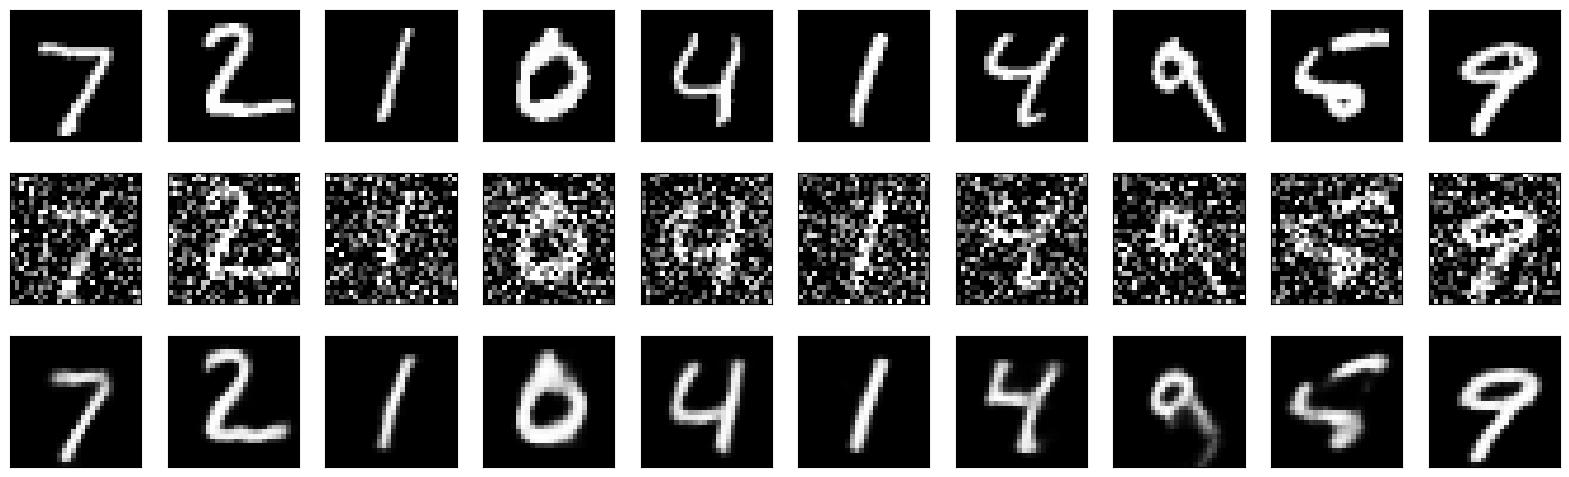

In [8]:
# Predict the denoised images
denoised_images = diffusion_model.predict(x_test_noisy)

# Visualize the results
n = 10  # Number of digits to display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

#### Step 6: Fine-tune the diffusion model 

Fine-tune the diffusion model by unfreezing some layers and retraining the model to improve its performance. 

**1. Unfreeze the model layers:** 
- Unfreeze the last few layers of the model to allow them to be retrained. 

**2. Compile and train the model:** 
- Recompile the model. 
- Train the model again for an additional 10 epochs. 


In [9]:
# Unfreeze the top layers of the model
for layer in diffusion_model.layers[-4:]:
    layer.trainable = True

# Compile the model again
diffusion_model.compile(optimizer='adam', loss='binary_crossentropy')  

# Train the model again
diffusion_model.fit(
    x_train_noisy,
    x_train,
    epochs=10,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.1019 - val_loss: 0.1008
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.1004 - val_loss: 0.1004
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.0997 - val_loss: 0.1006
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.0996 - val_loss: 0.1007
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0992 - val_loss: 0.1032
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0991 - val_loss: 0.1002
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.0991 - val_loss: 0.1009
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.0990 - val_loss: 0.1014
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.0991 - val_loss: 0.1009
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.0994 - val_loss: 0.1007


# Exercises

### Exercise 1: Modify the noise factor  

#### Objective: 
- Change the noise factor and see how it affects the model’s ability to denoise images.
#### Instructions:  
1. Change the noise factor to 0.3.  
2. Add noise to the training and test data sets with the new noise factor.  
3. Retrain the model with the new noisy data.

In [10]:
# Change the noise factor to 0.3
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.0)

# Train the model
diffusion_model.fit(
    x_train_noisy,
    x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0858 - val_loss: 0.0861
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0840 - val_loss: 0.0837
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0837 - val_loss: 0.0838
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0865 - val_loss: 0.0838
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0840 - val_loss: 0.0837
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0839 - val_loss: 0.0843
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0836 - val_loss: 0.0856
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0838 - val_loss: 0.0839
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0836 - val_loss: 0.0838
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0834 - val_loss: 0.0854
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0835 - val_loss: 0.0849
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 

### Exercise 2 - Add more layers to the model  

#### Objective: 
- Experiment with adding more layers to the model to see how it affects performance.

#### Instructions:
1. Add an additional Conv2D layer with 128 filters in the encoder.  
2. Add an additional Conv2DTranspose layer with 128 filters in the decoder.  
3. Rebuild, compile, and train the model.


In [11]:
# Add an additional Conv2D layer with 128 filters in the encoder
input_layer = Input(shape=(28, 28, 1))
x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_layer)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(28*28*64, activation='relu')(x)
x = Reshape((28, 28, 64))(x)
x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(64, (3, 3), activation='sigmoid', padding='same')(x)
x = Conv2DTranspose(32, (3, 3), activation='sigmoid', padding='same')(x)
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
diffusion_model = Model(input_layer, output_layer)

# Compile the model
diffusion_model.compile(optimizer='adam', loss='binary_crossentropy')

# Summary of the model
diffusion_model.summary()

# Train the model
diffusion_model.fit(
    x_train_noisy,
    x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50176)          │     6,472,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 128)    │        73,856 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 28, 28, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,944,033 (37.93 MB)

 Trainable params: 9,944,033 (37.93 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 0.2873 - val_loss: 0.2242
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.2159 - val_loss: 0.2511
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.2224 - val_loss: 0.2144
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.2183 - val_loss: 0.2231
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 0.2319 - val_loss: 0.2155
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 0.2242 - val_loss: 0.2373
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.2437 - val_loss: 0.2508
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - loss: 0.2465 - val_loss: 0.2277
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 0.2375 - val_loss: 0.2460
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 0.2421 - val_loss: 0.2346
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 0.2356 - val_loss: 0.2348
Epoch 12/50
469/469 ━━━━━━━━━━

### Exercise 3: Visualize the effect of noise  

#### Objective: 
- Compare the impact of different noise levels on the denoising performance of the model.

#### Instructions:  
1. Add noise with different factors (e.g., 0.1, 0.5, 0.7) to the test data.  
2. Use the model to predict the denoised images for each noise level.  
3. Visualize the original, noisy, and denoised images side by side for each noise level.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


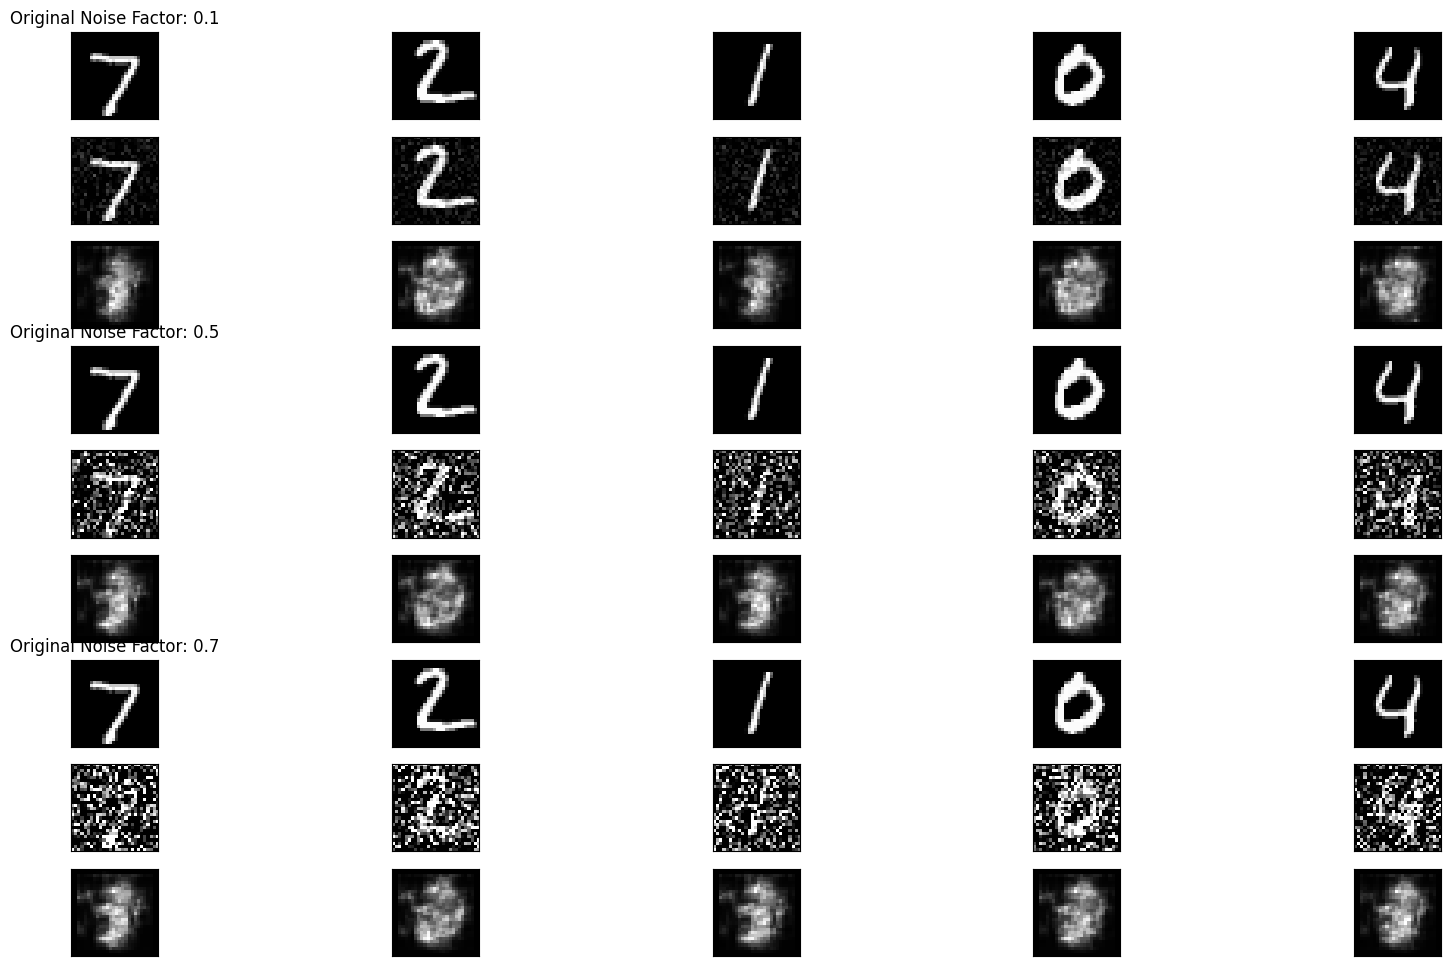

In [12]:
def add_noise_n_predict(noise_factor):
    x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
    x_test_noisy = np.clip(x_test_noisy, 0., 1.0)
    denoised_images = diffusion_model.predict(x_test_noisy)
    return x_test_noisy, denoised_images

# Noise levels to test
noise_levels = [0.1, 0.5, 0.7]

# Visualize the results
n = 5  # Number of digits to display
plt.figure(figsize=(20, 12))

for idx, noise_factor in enumerate(noise_levels):
    x_test_noisy, denoised_images = add_noise_n_predict(noise_factor)

    for i in range(n):
        # Display original
        ax = plt.subplot(3 * len(noise_levels), n, idx * n * 3 + i + 1)
        plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if i == 0:
            ax.set_title(f'Original Noise Factor: {noise_factor}')

        # Display noisy
        ax = plt.subplot(3 * len(noise_levels), n, idx * n * 3 + i + 1 + n)
        plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display denoised
        ax = plt.subplot(3 * len(noise_levels), n, idx * n * 3 + i + 1 + 2 * n)
        plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.show()